# Movie Revenue and Profit Prediction 

This notebook works through regression, classification, and clustering models related to predicting the revenue or profit of movies released between 1995 and June 2018.  The related GitHub for this project is here: https://github.com/georgetown-analytics/Box-Office.  

The raw data sources were cleaned, wrangled, and pre-processed in separate python codes stored here: https://github.com/georgetown-analytics/Box-Office/tree/master/codes.  These notebooks are for the modeling stage of the project.

In [88]:
import pandas as pd
import numpy as np
import pandas.io.sql as pd_sql
import sqlite3 as sql
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

import statsmodels.api as sm

from sklearn.ensemble import (BaggingClassifier, ExtraTreesClassifier, 
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.linear_model import (LinearRegression, LogisticRegressionCV, 
    LogisticRegression, SGDClassifier, Ridge, Lasso, ElasticNet, LassoCV, RidgeCV, ElasticNetCV)
from sklearn.svm import LinearSVC, NuSVC, SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB 

from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline

from yellowbrick.classifier import ClassificationReport, ROCAUC
from yellowbrick.features import FeatureImportances

from imblearn.over_sampling import SMOTE

from sklearn.tree import export_graphviz
import pydot

%matplotlib inline

In [89]:
con = sql.connect(r'c:\users\rebecca\projs\Box-Office\database\movies.db') 

movies = pd_sql.read_sql('select * from finalMovies_20180814', con, index_col='index')


# Regression Models

This section will look at whether we can predict the actual revenue of movies using regression modeling techniques.  

In [74]:
#Limit dataset to those with filled in Revenue, Budget, and Length columns.  Based on what I've seen, this helps to
#get rid of remaining duplicates in dataset.  Also helps to narrow down dataset to test profitability, where we
#need both revenue and budget filled in.  We could experiment with movies with revenue greater than $100,000, if 
#we choose to.
test = movies[(movies['Revenue_Real']>0)&(movies['Budget_Real']>0)&(movies['Length']>0)&(movies['Revenue_Actor_Real']>0)&
             (movies['Revenue_Director_Real']>0)&(movies['Revenue_Writer_Real']>0)]

#Put zero where null
test['Revenue_Actor_Real']=test['Revenue_Actor_Real'].apply(lambda x: 0 if pd.isnull(x) else x)
test['Revenue_Director_Real']=test['Revenue_Director_Real'].apply(lambda x: 0 if pd.isnull(x) else x)
test['Revenue_Writer_Real']=test['Revenue_Writer_Real'].apply(lambda x: 0 if pd.isnull(x) else x)

#Could experiment with logged values of revenue and budget
test['Revenue_Real_Log']=np.log(test['Revenue_Real'])
test['Budget_Real_Log']=np.log(test['Budget_Real'])
test['Revenue_Actor_Real_Log']=np.log(test['Revenue_Actor_Real'])
test['Revenue_Director_Real_Log']=np.log(test['Revenue_Director_Real'])
test['Revenue_Writer_Real_Log']=np.log(test['Revenue_Writer_Real'])

#Create a feature called 'constant' to use in regression model.
test['constant'] =1

C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [86]:
X = test[['constant', "Budget_Real", "Holiday", "Summer", "Spring", "Fall", "Winter",
'Rating_RT', 'Rating_IMDB', 'Rating_Metacritic','isCollection','Length',
'Genre_Drama', 'Genre_Comedy', 'Genre_Action_Adventure', 'Genre_Thriller_Horror',
 'Genre_Romance', 'Genre_Crime_Mystery', 'Genre_Animation', 'Genre_Scifi',
 'Genre_Documentary', 'Genre_Other',
'Rated_G_PG', 'Rated_PG-13', 'Rated_R', 'Rated_Other',
'Comp_Disney','Comp_DreamWorks', 'Comp_Fox', 'Comp_Lionsgate',
 'Comp_MGM', 'Comp_Miramax', 'Comp_Paramount', 'Comp_Sony',
 'Comp_Universal', 'Comp_WarnerBros', 'Comp_Other',  
'Revenue_Actor_Real','Revenue_Director_Real', 'Revenue_Writer_Real',
'Nominated_Major','Nominated_Minor', 'Won_Major', 'Won_Minor']]

y = test['Revenue_Real']

In [87]:
scaler = preprocessing.StandardScaler()
scaled_X = scaler.fit_transform(X)
#scaler = preprocessing.StandardScaler()
scaled_y = scaler.fit_transform(y)

model = sm.OLS((scaled_y), scaled_X)
results = model.fit()
print(results.summary())

ValueError: Expected 2D array, got 1D array instead:
array=[9.51507145e+08 4.34322700e+06 2.66337915e+08 ... 4.18959016e+07
 7.01063000e+06 2.08910957e+06].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

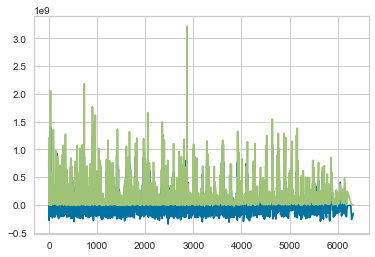

In [85]:
%matplotlib inline
plt.plot(results.fittedvalues)#, test['Revenue_Real'])
plt.plot(test['Revenue_Real'])

In [62]:
print(test['Revenue_Real'].head(5), test['Revenue_Real_Log'].head(5), np.exp(test['Revenue_Real_Log']).head(5))

index
2     9.515071e+08
3     4.343227e+06
5     2.663379e+08
9     2.254845e+06
10    1.216198e+09
Name: Revenue_Real, dtype: float64 index
2     20.673558
3     15.284128
5     19.400276
9     14.628592
10    20.918995
Name: Revenue_Real_Log, dtype: float64 index
2     9.515071e+08
3     4.343227e+06
5     2.663379e+08
9     2.254845e+06
10    1.216198e+09
Name: Revenue_Real_Log, dtype: float64


In [63]:
X_restricted = test[['constant', "Budget_Real_Log", "Summer", 'Rating_IMDB', 'Rating_Metacritic','isCollection','Length',
'Genre_Drama',  'Genre_Action_Adventure','Genre_Crime_Mystery', 'Genre_Animation', 'Genre_Scifi',
 'Genre_Documentary', 'Genre_Other', 'Rated_PG-13', 'Rated_R', 
'Comp_Disney','Comp_Fox', 'Comp_MGM', 'Comp_Sony','Comp_WarnerBros',  'Comp_Other',
'Revenue_Actor_Real_Log','Revenue_Director_Real_Log', 'Revenue_Writer_Real_Log'
]]
y = test["Revenue_Real_Log"]

In [64]:
model_restricted = sm.OLS(y, X_restricted)
results = model_restricted.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       Revenue_Real_Log   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     125.9
Date:                Sun, 19 Aug 2018   Prob (F-statistic):               0.00
Time:                        12:51:56   Log-Likelihood:                -3160.1
No. Observations:                1879   AIC:                             6370.
Df Residuals:                    1854   BIC:                             6509.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
constant              

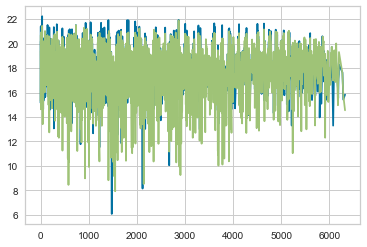

In [65]:
%matplotlib inline
plt.plot(results.fittedvalues)
plt.plot(test['Revenue_Real_Log'])

In [70]:
# Split up the data with the 'train test split' method.
seed=2
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_restricted, y, test_size = 0.2, random_state=seed)
lm = LinearRegression()
lm.fit(X_train, y_train)

print(" Training set MAE:", mean_absolute_error(np.exp(y_train), np.exp(lm.predict(X_train))), "dollars", '\n',
      "Training set r_squared:", r2_score(y_train, lm.predict(X_train)), '\n',
      "Testing set MAE:", mean_absolute_error(np.exp(y_test), np.exp(lm.predict(X_test))), "dollars", '\n',
      "Testing set r_squared:", r2_score(y_test, lm.predict(X_test)), '\n',)


 Training set MAE: 105336103.2215097 dollars 
 Training set r_squared: 0.6140381328382544 
 Testing set MAE: 108507214.52941906 dollars 
 Testing set r_squared: 0.6366505181567634 



In [68]:
print(test['Revenue_Real'].mean())

175145559.67112422


# Classification Models

We can also try to develop classes of movies in order to use classification models.  So, this section will look at whether we can predict movie profitability.  We will use a feature we created during the pre-processing step: "Profit_Bucket", which indicates whether a movie made less than its budget, same as its budget, twice its budget, three times, etc.  The classes are: <1x, [1-2x), [2-3x), [3-4x), [4-5x), and >=5x.  

In addition, we will create an additional feature called "Profit_Bucket_Binary" which will equal a 1 if the movie made at least twice its budget, and 0 if not.  We chose this threshold because in some of the literature regarding movie profitability, a rule-of-thumb some people follow is a movie likely makes a profit if it makes at least twice its production budget.  This is due to the extra costs of marketing, distribution, and other expenses.

The lines of code to run these models were from some labs we did in Dr. Bari's class and Dr. Bengfort's class.

### Create Profit Bucket Binary variable and set (X, y) train and test sets

We will create the new feature "Profit_Bucket_Binary", convert any "nan" in the historical cast/crew revenue columns to 0, and set the train and test sets that we will use for all the classification model testing. 

In [98]:
#Limit dataset to those with filled in Revenue, Budget, and Length columns.  Based on what I've seen, this helps to
#get rid of remaining duplicates in dataset.  Also helps to narrow down dataset to test profitability, where we
#need both revenue and budget filled in.  We could experiment with movies with revenue greater than $100,000, if 
#we choose to.
test = movies[(movies['Revenue_Real']>0)&(movies['Budget_Real']>0)&(movies['Length']>0)]

#Make binary variable for if movie made at least 2x budget
test['Profit_Bucket_Binary']=np.where(test['Profit_Bucket']=='<1x', 0, np.where(test['Profit_Bucket']=='[1-2x)', 
                        0, np.where(test['Profit_Bucket']=='[2-3x)', 1, np.where(test['Profit_Bucket']=='[3-4x)', 
                        1, np.where(test['Profit_Bucket']=='[4-5x)', 1, np.where(test['Profit_Bucket']=='>=5x', 1, ''))))))

#Put zero where null
test['Revenue_Actor_Real']=movies['Revenue_Actor_Real'].apply(lambda x: 0 if pd.isnull(x) else x)
test['Revenue_Director_Real']=movies['Revenue_Director_Real'].apply(lambda x: 0 if pd.isnull(x) else x)
test['Revenue_Writer_Real']=movies['Revenue_Writer_Real'].apply(lambda x: 0 if pd.isnull(x) else x)


C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

0    2539
1    1875
Name: Profit_Bucket_Binary, dtype: int64


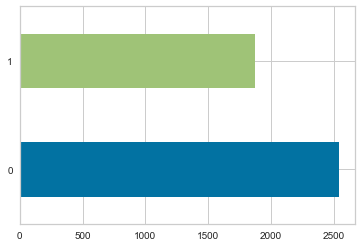

In [94]:
#Show distribution of profit bucket binary
print(test['Profit_Bucket_Binary'].value_counts())
test['Profit_Bucket_Binary'].value_counts().plot(kind='barh')

In [99]:
#Set X, y
X = test[["Budget_Real", "Holiday", "Summer", "Spring", "Fall", "Winter",
'Rating_RT', 'Rating_IMDB', 'Rating_Metacritic','isCollection','Length',
'Genre_Drama', 'Genre_Comedy', 'Genre_Action_Adventure', 'Genre_Thriller_Horror',
 'Genre_Romance', 'Genre_Crime_Mystery', 'Genre_Animation', 'Genre_Scifi',
 'Genre_Documentary', 'Genre_Other',
'Rated_G_PG', 'Rated_PG-13', 'Rated_R', 'Rated_Other',
'Comp_Disney','Comp_DreamWorks', 'Comp_Fox', 'Comp_Lionsgate',
 'Comp_MGM', 'Comp_Miramax', 'Comp_Paramount', 'Comp_Sony',
 'Comp_Universal', 'Comp_WarnerBros', 'Comp_Other',  
'Revenue_Actor_Real','Revenue_Director_Real', 'Revenue_Writer_Real']]
y = test["Profit_Bucket_Binary"]

seed=3
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2, random_state=seed)

In [104]:
classifiers = [
    LogisticRegressionCV(random_state=1, cv=5),
    LogisticRegression(random_state=1),
    RandomForestClassifier(n_estimators=50, oob_score=True),
    #XGBClassifier(), 
    BaggingClassifier(), 
    ExtraTreesClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    MultinomialNB(),
    GaussianNB(),
    #SVC(kernel='linear'),
    SVC(kernel='rbf'),
    #SVC(kernel='poly', degree=3),
    KNeighborsClassifier()]

LogisticRegressionCV [0.71428571 0.43050847]


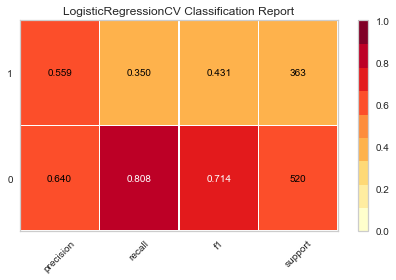

LogisticRegression [0.71319149 0.42978003]


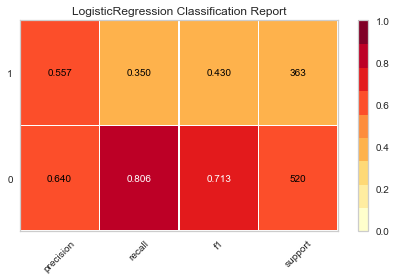

RandomForestClassifier [0.77285068 0.62027231]


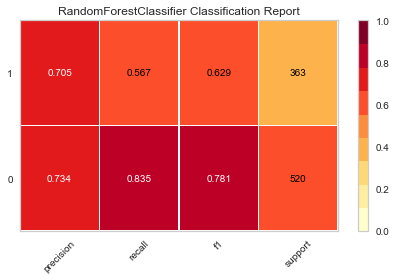

C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier [0.76416819 0.61607143]


C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


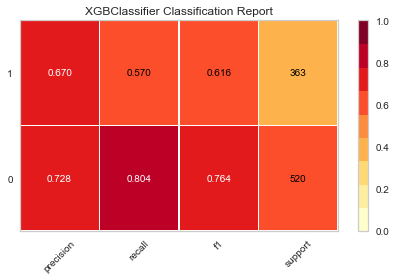

BaggingClassifier [0.75749319 0.59849624]


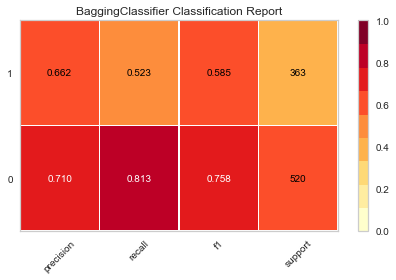

ExtraTreesClassifier [0.75136116 0.5873494 ]


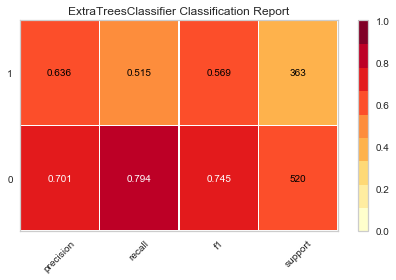

AdaBoostClassifier [0.75116496 0.61471861]


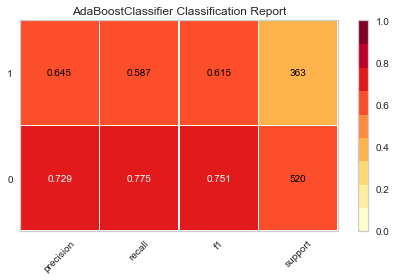

GradientBoostingClassifier [0.76584022 0.62333826]


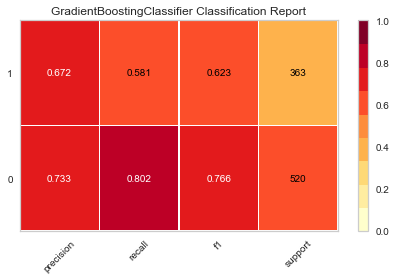

MultinomialNB [0.6967854  0.43252033]


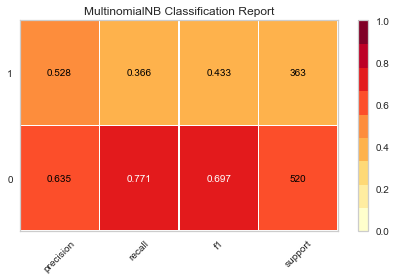

GaussianNB [0.74626866 0.34482759]


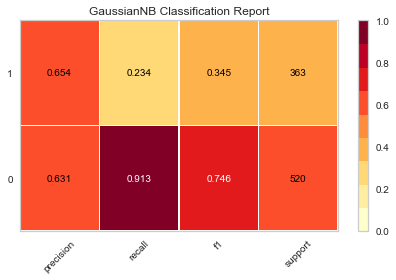

C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC [0.74126871 0.        ]


C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


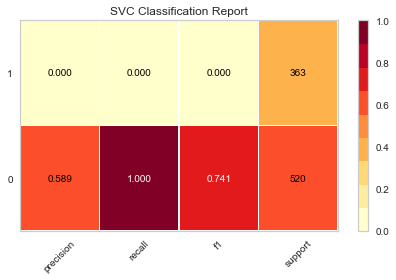

KNeighborsClassifier [0.64689527 0.44541485]


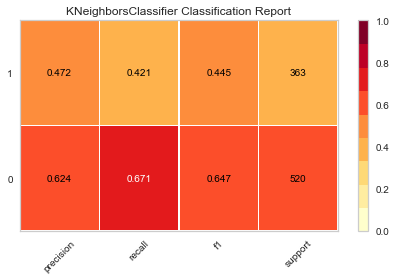

In [97]:
for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    expected = y_test
    predicted = clf.predict(X_test)
    print(name, (f1_score(expected, predicted, average=None)))
    
    oz = ClassificationReport(clf, support=True)
    oz.fit(X_train, y_train)
    oz.score(X_test, y_test)
    oz.poof()
    

# Classification Models, part 2

Let's run those same models on the original 6 classes we had in the "Profit_Bucket" feature to see which models can classify movies under multiple classes.  

### Create (X, y) train and test sets using "Profit_Bucket" feature

We set the set the train and test sets that we will use for all the classification model testing. 

<1x       1710
[1-2x)     829
[2-3x)     642
>=5x       632
[3-4x)     354
[4-5x)     247
Name: Profit_Bucket, dtype: int64


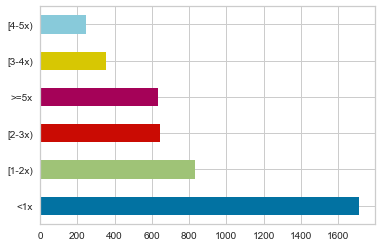

In [8]:
#Show distribution of profit bucket binary
print(test['Profit_Bucket'].value_counts())
test['Profit_Bucket'].value_counts().plot(kind='barh')

In [105]:
#Keep same X as original Classification models, but change y to "Profit_Bucket" instead of "Profit_Bucket_Binary"
y = test["Profit_Bucket"]

seed=3
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2, random_state=seed)

In [106]:
sm = SMOTE(random_state=12)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegressionCV [0.2781457  0.0483871  0.         0.23794212 0.02702703 0.14790997]


C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


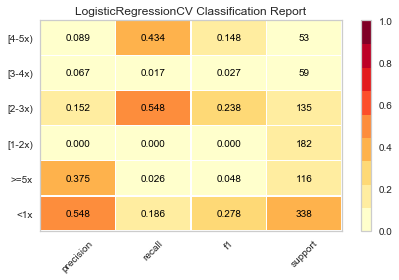

LogisticRegression [0.27433628 0.0483871  0.         0.23832528 0.02702703 0.14696486]


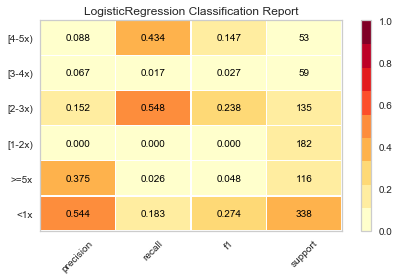

RandomForestClassifier [0.68069307 0.37815126 0.27672956 0.21052632 0.14141414 0.08      ]


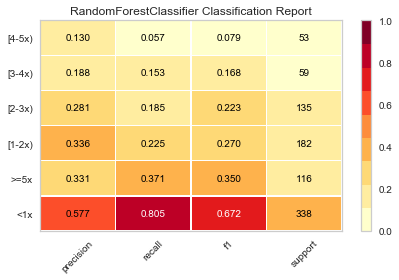

BaggingClassifier [0.64524766 0.37547893 0.26347305 0.19469027 0.11214953 0.13186813]


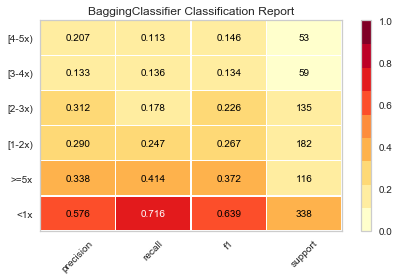

ExtraTreesClassifier [0.62864385 0.27004219 0.26006192 0.2920354  0.07272727 0.07407407]


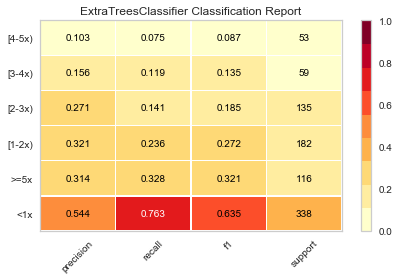

AdaBoostClassifier [0.62734584 0.34285714 0.28654971 0.21097046 0.09803922 0.21276596]


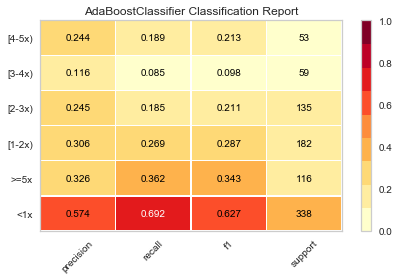

GradientBoostingClassifier [0.66093366 0.40506329 0.23287671 0.27160494 0.07920792 0.12658228]


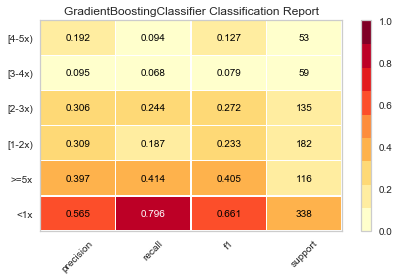

MultinomialNB [0.53929867 0.05673759 0.10970464 0.08461538 0.17094017 0.10869565]


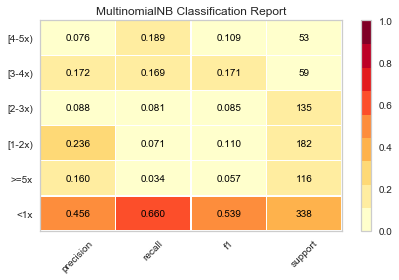

GaussianNB [0.60921844 0.08571429 0.10762332 0.18604651 0.02898551 0.21487603]


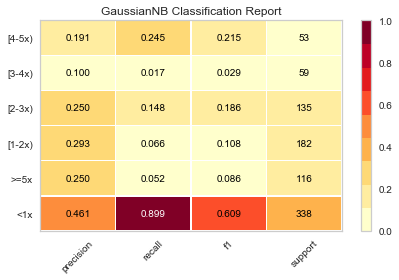

C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC [0.         0.01694915 0.         0.         0.         0.11373391]


C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


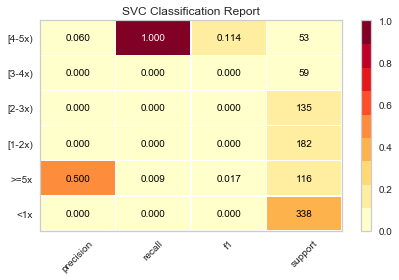

KNeighborsClassifier [0.36048527 0.2137931  0.14501511 0.12927757 0.0969697  0.1       ]


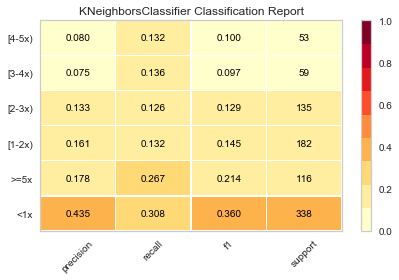

In [107]:
for clf in classifiers:
    clf.fit(X_train_res, y_train_res)
    name = clf.__class__.__name__
    expected = y_test
    predicted = clf.predict(X_test)
    print(name, (f1_score(expected, predicted, average=None)))
    
    oz = ClassificationReport(clf, support=True)
    oz.fit(X_train_res, y_train_res)
    oz.score(X_test, y_test)
    oz.poof()

*********************************
Experiment with Ridge, Lasso, ElasticNet....not working yet.
*********************************

In [41]:

#model = Lasso()
model = Lasso(alpha=0.1)
results=model.fit(features, labels)
#print(list(zip(features, model.coef_.tolist())))
model.score(features, labels)

0.09965424812008616

In [42]:

#model = Ridge()
model = Ridge(alpha=0.001)
model.fit(features, labels)
#print(list(zip(features, model.coef_.tolist())))
model.score(features, labels)

C:\Users\Rebecca\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.784018604550782e-26 / 1.1102230246251565e-16
  RuntimeWarning)


0.20399609272029495

In [43]:
#model = ElasticNet()
model = ElasticNet(l1_ratio = 0.00001)
model.fit(features, labels)
#print(list(zip(features, model.coef_.tolist())))
model.score(features, labels)

0.1264511206180554